# Compare methods using lupus data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np

In [8]:
data_path = '/data_volume/memento/method_comparison/lupus/'

In [22]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [10]:
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]

### Compute the concordance curve

In [11]:
def concordance_curve(ref1, ref2, ref3, ref4, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        overlap.append((a+b+c+d)/4)
        
    return np.arange(1, k+1), np.array(overlap)

In [12]:
def concordance_auc(ref1, ref2, ref3, ref4, x, k=300):
    count = 0
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        count += (a+b+c+d)/4
        
    return count / (k*(k+1)/2)

### Read results - cell type comparison

In [11]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger_lrt.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    # ('WLS','T4_vs_cM.sc.wls.csv', ['logFC','PValue', 'FDR']),
    ('sum_GLM', 'T4_vs_cM.sc.sum_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_mean_GLM', 'T4_vs_cM.sc.scaled_mean_glm.csv', ['logFC','PValue', 'FDR']),
    # ('scaled_iv_mean_GLM', 'T4_vs_cM.sc.scaled_iv_mean_glm.csv', ['logFC', 'PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
    ('memento', 'T4_vs_cM.sc.memento.csv', ['de_coef','de_pval', 'de_fdr']),
    ('weighted_mean_WLS', 'T4_vs_cM.sc.weighted_mean_wls.csv', ['logFC','PValue', 'FDR'])
    
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

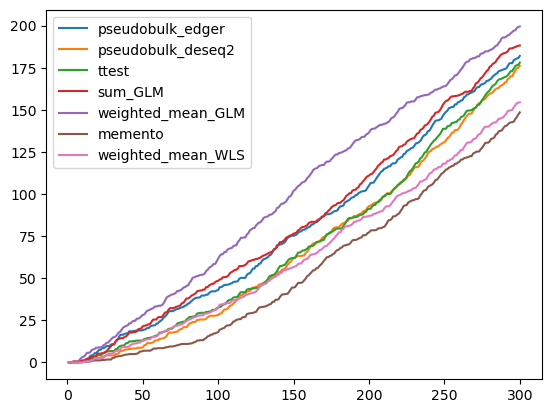

In [12]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()

<AxesSubplot: >

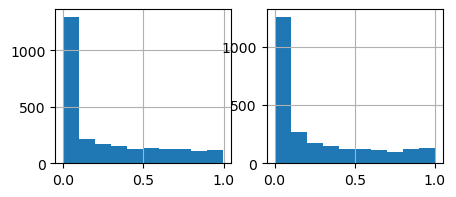

In [13]:
plt.figure(figsize=(5,2))

plt.subplot(1, 2, 1)
results[4]['PValue'].hist()

plt.subplot(1, 2, 2)
results[-3]['PValue'].hist()

### Read results with repeated trials

In [13]:
all_results = []
for numcells in [150]:
    for trial in range(50):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('edgeR','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('DESeq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','T4_vs_cM.sc.ttest.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MWU','T4_vs_cM.sc.mwu.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('MAST','T4_vs_cM.sc.MAST.{}.{}.csv'.format(numcells, trial), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'T4_vs_cM.sc.weighted_mean_glm.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results[4:])]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]

In [14]:
# plt.figure(figsize=(3,3))
# for idx, (x,y) in enumerate(curves):
#     plt.plot(x,y, label=name_paths[idx+4][0])
# plt.legend()
# plt.xlabel('Number of top genes')
# plt.ylabel('Overlap with bulk RNA-seq')

In [15]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

/tmp/ipykernel_14545/200401537.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_14545/200401537.py:14: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.stripplot(


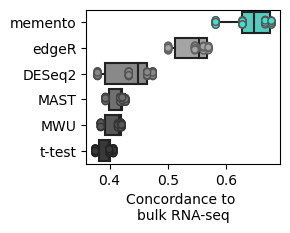

In [23]:
plt.figure(figsize=(2.5,2))
sns.boxplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df.query('numcells==150'), 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        'MAST',
        'MWU',
        't-test',],
    linewidth=1,
    palette=pal)
plt.xlabel('Concordance to \nbulk RNA-seq')
plt.ylabel('')
plt.savefig('lupus_bulk_comparison.pdf', bbox_inches='tight')

### Single example

In [139]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']),
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

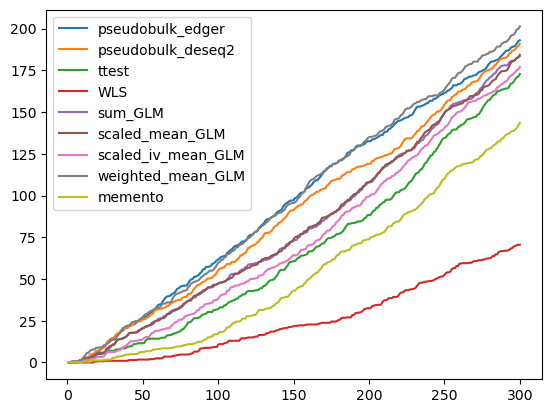

In [142]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()